In [29]:
import requests as req
import pandas as pd
import sqlite3 as sql
import requests
from functools import reduce
import numpy as np
import os.path
from os import path
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sqlite_file = 'salaries_data.sql'

In [3]:
db = sql.connect(":memory:")

In [4]:
sql_file = open(sqlite_file)
sql_as_string = sql_file. read()
db. executescript(sql_as_string)

## Data  Manipulation

In [5]:
salary_query= """
SELECT 
 firstname, lastname, department, salary, position
FROM Salaries
"""

In [6]:
salaries = pd.read_sql(salary_query, db)

In [7]:
salaries.head()

,firstname,lastname,department,salary,position
0,DJ,Durkin,PRES,881010.96,Head Coach
1,Darryll J,Pines,PRES,765000.00,President
2,Wallace,Loh,PRES,734565.88,Spec Asst to the Pres
3,Mark,Turgeon,PRES,723312.99,Head Coach
4,Brenda S,Frese,PRES,659386.43,Head Coach BB


In [8]:
def count_nonempty(d): 
    total = 0
    for k in d.keys():
        if (d.get(k) != None):
            total += 1
    print("the non empty total", total)

In [9]:
headers = {
  'Accept': 'application/json'
}

In [10]:
def fetch_profs(): 


    profs = dict()
    matched_profs = dict()

    for i in range(0, 10000, 1000):
        r = requests.get('https://api.planetterp.com/v1/professors?reviews=true', params={
          'limit': '1000',
          'offset': i,
        }, headers = headers)

        for e in r.json():
            profs[e.get("slug")] = e
            matched_profs[e.get("slug")] = None

    
    print(len(profs.values()))
    return (profs, matched_profs)

In [11]:
def find_closest_match(name, matches):
    firstname = name.split(" ")[0]
    ret = [ m  for m in matches if m[0].find(firstname) >= 0 ]
    if(len(ret) > 0):
        return ret[0]
    return None
def calc_avg_review(revs):
    length = len(revs)
    if(length == 0):
        return np.nan
    total = 0
    for r in revs:
        total += r.get("rating")
    return total / length
        

In [12]:
def get_department(dep, profs, matched_profs):
    matches = dict()

    for prof in profs.values():
        
        slug = prof.get("slug")
        name = prof.get("name")
        courses = prof.get("courses")
        avg_rating = calc_avg_review(prof.get("reviews"))
        
        if(matched_profs.get(slug) != None):
            continue

        lastname = name.split(" ")[-1]

        salary_query= f"""
            SELECT 
            firstname, 
            lastname,
            department,
            salary,
            position
            FROM Salaries
            WHERE lastname like "{lastname}"
            AND department = "{dep}"
        """
        rows = list(db.execute(salary_query))
        matches[lastname] = (len(rows), rows, name, slug, courses, avg_rating)
        

    for match in matches.keys():
        (length, v, name, slug, courses, avg_rating) = matches.get(match)
        if(length > 0):
           
            value = find_closest_match(name, v)
         
            if(value != None):
                
                matched_profs[slug] = (
                    value[0],
                    value[1],
                    value[2],
                    value[3],
                    value[4],
                    avg_rating,
                    slug,
                    name,
                    "-".join(courses),
                    len(courses)
                )
                

    return

In [13]:
data = []

In [14]:
def fetch_matched_salaries():
    if(path.isfile("matched_salaries.csv")):
        return pd.read_csv("matched_salaries.csv")
    
    
    (profs, matched_profs) = fetch_profs()
    
    arr = list(set(salaries["department"]))
    for dep in arr:   
        get_department(dep, profs, matched_profs)
        
    data = [ list(v)  for v in matched_profs.values() if v != None]
    matched_salaries = pd.DataFrame(data, columns=['firstname', 'lastname', 'department', 'salary', "position", "avg_rating", 'slug', "planetTerpName", "courses", "num_courses"])
    matched_salaries.to_csv(path_or_buf="matched_salaries.csv", index=False)
    return matched_salaries


In [41]:
matched_salaries = fetch_matched_salaries()



matched_salaries = matched_salaries[matched_salaries['position'].str.contains("Professor") | matched_salaries['position'].str.contains("Lecturer")]
print(matched_salaries.department.unique())

matched_salaries.head()

['BSOS' 'ENGR' 'PLCY' 'ARHU' 'AGNR' 'INFO' 'CMNS' 'JOUR' 'BMGT' 'EDUC'
 'EXST' 'SPHL' 'UGST' 'SVPAAP' 'ARCH' 'VPR']


,firstname,lastname,department,salary,position,avg_rating,slug,planetTerpName,courses,num_courses
0,A W,Kruglanski,BSOS,322501.74,Distinguished Univ Professor,2.0,kruglanski,A Kruglanski,PSYC743-PSYC748M-PSYC489H-PSYC489T-PSYC789-PSY...,9
1,Aaron,Finkle,BSOS,75054.05,Lecturer,3.5,finkle,Aaron Finkle,ECON306-ECON641-ECON321-ECON456-ECON488K-BUSO604,6
2,Aaron Gilad,Kusne,ENGR,17945.31,Lecturer,NaN,kusne,Aaron Kusne,ENMA489L,1
3,Aaron Wolf,Mannes,PLCY,15300.00,Lecturer,NaN,mannes,Aaron Mannes,PLCY780,1
4,Aaron George,Swanlek,ARHU,37087.20,Lecturer,5.0,swanlek,Aaron Swanlek,COMM107,1


In [42]:
def fetch_reviewsData(_data):
    if(path.isfile("reviews.csv")):
        return pd.read_csv("reviews.csv")
        
    reviews_data = []
    for v in _data:

        r = requests.get('https://api.planetterp.com/v1/professor', params={
          'name': v,  'reviews': 'true'
        }, headers = headers).json()


        slug = r.get("slug")
        revs = r.get("reviews")
        if(revs == None):
            continue

        for rev in revs:  

            reviews_data.append([ 
                slug,
                rev.get("rating"),  
                rev.get("expected_grade"), 
                rev.get("course"),
                rev.get("review"),
            ])   
    reviews_df = pd.DataFrame(reviews_data, columns=['slug', 'rating', 'expected_grade', 'course', 'review'])
    reviews_df.to_csv(path_or_buf="reviews.csv", index=False)
    return  reviews_df



In [43]:
reviews_df = fetch_reviewsData(list(matched_salaries["planetTerpName"]))
reviews_df.head()

,slug,rating,expected_grade,course,review
0,kruglanski,2,NaN,PSYC489H,"DO NOT TAKE PSYC489H ""Motivated Social Cogniti..."
1,finkle,5,B+,ECON306,I really suggest Aaron Finkle for anyone who n...
2,finkle,2,A-,ECON306,Only parts of the syllabus were published at a...
3,swanlek,5,A+,COMM107,This prof is the COOLEST you could ever have. ...
4,swanlek,5,A+,COMM107,Aaron is the NICEST guy ever! He is incredibly...


In [44]:
# reviews_df.to_csv(path_or_buf="reviews.csv", index=False)

In [45]:
data

[]

In [46]:
# word vector classifications - gensim

# word cloud with reviews (bag of words)
    # words that describe popular profesors
    
# scatter plot of professor salaries vs ratings
# scatter plot of depart salaries vs ratings

# consider the title of the professors which may be a reason for increased salary


## EDA

In [47]:
dept_avg = matched_salaries.groupby("department").mean().sort_values(by=["salary"], ascending=False)
dept_avg
dept_avg = dept_avg.dropna()

-4.56370455468363e-06
4.419891028760129


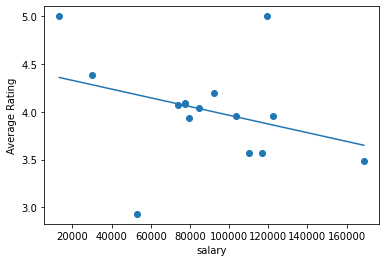

In [48]:
plt.scatter(dept_avg['salary'], dept_avg['avg_rating'])
plt.xlabel('salary')
plt.ylabel('Average Rating')

m,b = np.polyfit(dept_avg['salary'], dept_avg['avg_rating'], 1)
print(m)
print(b)

plt.plot(dept_avg['salary'], m * dept_avg['salary'] + b)

plt.show()


-3.4776092920450564e-06
4.192418795804199


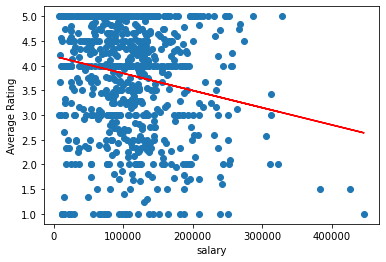

In [51]:
prof_salary = matched_salaries.dropna(subset = ['avg_rating'])

prof_salary = prof_salary[prof_salary['position'].str.contains("Professor") | prof_salary['position'].str.contains("Lecturer")]

plt.scatter(prof_salary['salary'], prof_salary['avg_rating'])
plt.xlabel('salary')
plt.ylabel('Average Rating')

m,b = np.polyfit(prof_salary['salary'], prof_salary['avg_rating'], 1)
print(m)
print(b)

plt.plot(prof_salary['salary'], m * prof_salary['salary'] + b, color = 'red')

plt.show()

         firstname    lastname department     salary  \
0              A W  Kruglanski       BSOS  322501.74   
1            Aaron      Finkle       BSOS   75054.05   
4     Aaron George     Swanlek       ARHU   37087.20   
9          Abhinav     Bhatele       CMNS  174021.38   
11         Abigail      McEwen       ARHU   95596.05   
...            ...         ...        ...        ...   
2173         Tunay       Tunca       BMGT  252371.18   
2175       Tyson T      Slocum       UGST   11616.64   
2179           Uzi     Vishkin       CMNS   83422.01   
2180   Valentine C    Hacquard       ARHU  144228.00   
2183     Valerie K     Orlando       ARHU  110941.41   

                          position  avg_rating             slug  \
0     Distinguished Univ Professor    2.000000       kruglanski   
1                         Lecturer    3.500000           finkle   
4                         Lecturer    5.000000          swanlek   
9              Assistant Professor    5.000000          bha

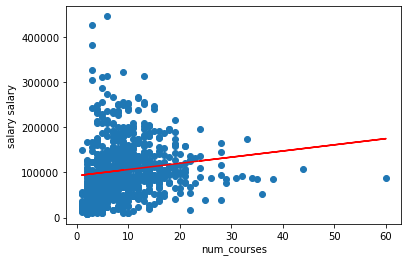

In [52]:
prof_salary = matched_salaries.dropna(subset = ['avg_rating'])


print(prof_salary)

plt.scatter(prof_salary['num_courses'], prof_salary['salary'])
plt.xlabel('num_courses')
plt.ylabel('salary salary')

m,b = np.polyfit(prof_salary['num_courses'], prof_salary['salary'], 1)
print(m)
print(b)

plt.plot(prof_salary['num_courses'], m * prof_salary['num_courses'] + b, color = 'red')

plt.show()

In [53]:
matched_salaries.corr()

,salary,avg_rating,num_courses
salary,1.000000,-0.187235,0.163427
avg_rating,-0.187235,1.000000,-0.026072
num_courses,0.163427,-0.026072,1.000000


[Text(0, 0.5, 'salary'),
 Text(0, 1.5, 'avg_rating'),
 Text(0, 2.5, 'num_courses')]

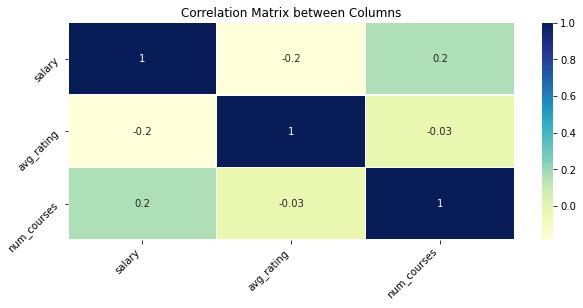

In [54]:
plt.subplots(figsize = (10,4))
g = sns.heatmap(matched_salaries.corr(), annot = True, cmap = "YlGnBu", fmt = '.1g', linewidths=.5,)

g.set_title("Correlation Matrix between Columns")
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_yticklabels(g.get_yticklabels(), rotation=45, horizontalalignment='right')

In [64]:
dept_features = pd.get_dummies(matched_salaries['department'], drop_first = True, prefix = 'dept')
print(dept_features)

std_features = matched_salaries[['avg_rating', 'salary', 'num_courses']]

#combine our data
comb_features = pd.concat([std_features, dept_features], axis = 1)
for i in filter(lambda i : i!= 'AGNR', matched_salaries['department'].unique()):
    comb_features['salary*' + i] = comb_features['dept_' + i]*comb_features['salary']
    
comb_features.corr()

      dept_ARCH  dept_ARHU  dept_BMGT  dept_BSOS  dept_CMNS  dept_EDUC  \
0             0          0          0          1          0          0   
1             0          0          0          1          0          0   
2             0          0          0          0          0          0   
3             0          0          0          0          0          0   
4             0          1          0          0          0          0   
...         ...        ...        ...        ...        ...        ...   
2179          0          0          0          0          1          0   
2180          0          1          0          0          0          0   
2181          0          1          0          0          0          0   
2183          0          1          0          0          0          0   
2184          0          0          0          0          1          0   

      dept_ENGR  dept_EXST  dept_INFO  dept_JOUR  dept_PLCY  dept_SPHL  \
0             0          0          0

,avg_rating,salary,num_courses,dept_ARCH,dept_ARHU,dept_BMGT,dept_BSOS,dept_CMNS,dept_EDUC,dept_ENGR,...,salary*CMNS,salary*JOUR,salary*BMGT,salary*EDUC,salary*EXST,salary*SPHL,salary*UGST,salary*SVPAAP,salary*ARCH,salary*VPR
avg_rating,1.000000,-0.187235,-0.026072,-0.046943,0.125274,-0.079929,0.042007,-0.130555,0.044064,-0.084897,...,-0.114778,0.035415,-0.097492,0.037911,0.035604,0.005602,0.025146,0.081872,-0.029598,NaN
salary,-0.187235,1.000000,0.163427,-0.109490,-0.208002,0.276986,0.117037,0.115380,-0.028855,0.055540,...,0.274614,0.029488,0.428503,0.073459,-0.150622,0.018428,-0.063038,0.069756,-0.008714,0.042126
num_courses,-0.026072,0.163427,1.000000,-0.055575,0.267717,-0.006573,-0.035803,0.005208,0.007717,-0.088910,...,0.008277,0.003849,0.008660,0.028892,-0.064912,0.025347,-0.043034,-0.062091,-0.001861,-0.021250
dept_ARCH,-0.046943,-0.109490,-0.055575,1.000000,-0.085273,-0.042653,-0.055777,-0.071739,-0.039470,-0.058685,...,-0.062867,-0.017802,-0.036725,-0.033920,-0.018642,-0.029430,-0.013042,-0.013825,0.742920,-0.003908
dept_ARHU,0.125274,-0.208002,0.267717,-0.085273,1.000000,-0.147256,-0.192566,-0.247674,-0.136269,-0.202608,...,-0.217045,-0.061461,-0.126791,-0.117106,-0.064361,-0.101605,-0.045027,-0.047732,-0.063351,-0.013493
dept_BMGT,-0.079929,0.276986,-0.006573,-0.042653,-0.147256,1.000000,-0.096320,-0.123884,-0.068161,-0.101343,...,-0.108564,-0.030742,0.861024,-0.058576,-0.032193,-0.050822,-0.022522,-0.023875,-0.031688,-0.006749
dept_BSOS,0.042007,0.117037,-0.035803,-0.055777,-0.192566,-0.096320,1.000000,-0.162003,-0.089133,-0.132525,...,-0.141969,-0.040202,-0.082934,-0.076599,-0.042098,-0.066459,-0.029452,-0.031221,-0.041438,-0.008826
dept_CMNS,-0.130555,0.115380,0.005208,-0.071739,-0.247674,-0.123884,-0.162003,1.000000,-0.114641,-0.170451,...,0.876335,-0.051707,-0.106667,-0.098520,-0.054146,-0.085478,-0.037881,-0.040156,-0.053296,-0.011352
dept_EDUC,0.044064,-0.028855,0.007717,-0.039470,-0.136269,-0.068161,-0.089133,-0.114641,1.000000,-0.093781,...,-0.100464,-0.028449,-0.058688,0.859376,-0.029791,-0.047030,-0.020842,-0.022094,-0.029323,-0.006246
dept_ENGR,-0.084897,0.055540,-0.088910,-0.058685,-0.202608,-0.101343,-0.132525,-0.170451,-0.093781,1.000000,...,-0.149372,-0.042298,-0.087259,-0.080593,-0.044294,-0.069925,-0.030988,-0.032849,-0.043599,-0.009286
